
# Mushroom Toxicity — Logistic Regression with Dynamic Partial Inputs (MC Sampling)

This notebook:
1. Loads `mushrooms.csv` and feature importances from RandomForest (reads `/mnt/data/mushroom_feature_importances.csv`; recomputes if missing).
2. Keeps only features with **Importance ≥ 0.02** dynamically.
3. Trains a **Logistic Regression** model with **One-Hot Encoding**.
4. Provides `predict_partial()` which accepts **partial** user inputs and uses **Monte Carlo sampling** over missing features based on empirical distributions to return:
   - Mean probability of being poisonous
   - 5th–95th percentile interval
   - Final label using a configurable threshold (default 0.5)
5. Saves artifacts: pipeline, kept-features, category choices.

> Assumption: Users will select values from predefined choices (no unseen categories), but the encoder is still set to handle unknowns safely.


In [62]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import joblib
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
DATA_PATH = Path("data/output/mushrooms_new_imputed.csv")
IMPORTANCE_CSV = Path("data/mushroom_feature_importances.csv")
ART_DIR = Path("mushroom_lr_artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)


In [70]:
# === Load dataset ===
df = pd.read_csv(DATA_PATH)
assert "class" in df.columns, "Target column 'class' not found."

# === Load precomputed RF feature importances ===
IMPORTANCE_CSV = Path("data/output/mushroom_feature_importances.csv")
importances = pd.read_csv(IMPORTANCE_CSV).sort_values("Importance", ascending=False).reset_index(drop=True)

display(importances)

# === Select kept features by threshold ===
THRESH = 0.00  # 3%
kept_features = importances.loc[importances["Importance"] >= THRESH, "Feature"].tolist()
kept_features = [f for f in kept_features if f in df.columns and f != "class"]
print(f"Kept {len(kept_features)} features (Importance ≥ {THRESH}):")
kept_features


,Feature,Importance
0,odor,0.260803
1,gill-color,0.081722
2,spore-print-color,0.073256
3,gill-size,0.057377
4,ring-type,0.051282
5,stalk-surface-above-ring,0.045363
6,population,0.044326
7,cap-color,0.043607
8,habitat,0.041704
9,stalk-color-below-ring,0.041186


Kept 21 features (Importance ≥ 0.0):


['odor',
 'gill-color',
 'spore-print-color',
 'gill-size',
 'ring-type',
 'stalk-surface-above-ring',
 'population',
 'cap-color',
 'habitat',
 'stalk-color-below-ring',
 'stalk-color-above-ring',
 'stalk-surface-below-ring',
 'cap-shape',
 'bruises',
 'cap-surface',
 'gill-spacing',
 'ring-number',
 'stalk-shape',
 'veil-color',
 'gill-attachment',
 'veil-type']

save the feature to json

In [64]:
# === Save kept features to JSON ===
json_path = ART_DIR / "kept_features.json"
with open(json_path, "w") as f:
    json.dump(kept_features, f, indent=2)

print(f"\n✅ Saved kept features to: {json_path}")


✅ Saved kept features to: mushroom_lr_artifacts\kept_features.json


In [65]:
# === Train Logistic Regression with One-Hot Encoding ===

X = df[kept_features].copy()
y = df["class"].map({"e": 0, "p": 1})  # poison=1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# === One-Hot Encoding + Logistic Regression Pipeline ===
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

pipe = Pipeline(steps=[
    ("onehot", ohe),
    ("clf", LogisticRegression(
        max_iter=200,
        solver="lbfgs"
    ))
])

# === Step 1: Cross-validation on training data ===
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="roc_auc")
print(f"5-Fold CV ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# === Step 2: Fit the final model on full training set ===
pipe.fit(X_train, y_train)

# === Step 3: Evaluate on hold-out test set ===
y_proba = pipe.predict_proba(X_test)[:, 1]

threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"\nThreshold = {threshold}")
print(f"Final Test Accuracy: {acc:.4f}  |  ROC-AUC: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


5-Fold CV ROC-AUC Scores: [0.92394441 0.92581806 0.92334261 0.92158139 0.91950487]
Mean CV ROC-AUC: 0.9228 ± 0.0021

Threshold = 0.4
Final Test Accuracy: 0.8348  |  ROC-AUC: 0.9232

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      2669
           1       0.79      0.87      0.83      2265

    accuracy                           0.83      4934
   macro avg       0.84      0.84      0.83      4934
weighted avg       0.84      0.83      0.84      4934

Confusion Matrix:
 [[2141  528]
 [ 287 1978]]


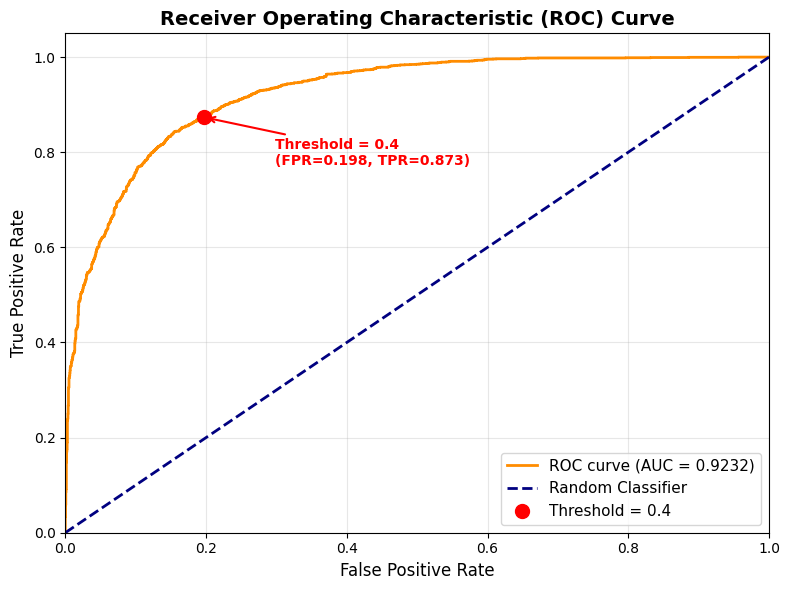

ROC-AUC Score: 0.9232
Threshold = 0.4: FPR = 0.1978, TPR = 0.8733


In [ ]:
# === ROC Curve Visualization ===
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)

# Find the point on ROC curve corresponding to threshold = 0.4
# Calculate FPR and TPR for the threshold
y_pred_thresh = (y_proba >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
fpr_thresh = fp / (fp + tn) if (fp + tn) > 0 else 0
tpr_thresh = tp / (tp + fn) if (tp + fn) > 0 else 0

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
# Mark the threshold point
plt.plot(fpr_thresh, tpr_thresh, 'ro', markersize=10, label=f'Threshold = {threshold}')
plt.annotate(f'Threshold = {threshold}\n(FPR={fpr_thresh:.3f}, TPR={tpr_thresh:.3f})', 
             xy=(fpr_thresh, tpr_thresh), 
             xytext=(fpr_thresh + 0.1, tpr_thresh - 0.1),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red', fontweight='bold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {auc:.4f}")
print(f"Threshold = {threshold}: FPR = {fpr_thresh:.4f}, TPR = {tpr_thresh:.4f}")


In [67]:
# === Category choices & empirical distributions for MC sampling ===
category_choices = {
    col: sorted(X_train[col].dropna().unique().tolist()) for col in kept_features
}

empirical_probs = {}
for col in kept_features:
    vc = X_train[col].value_counts(normalize=True)
    empirical_probs[col] = {cat: float(vc.get(cat, 0.0)) for cat in category_choices[col]}

print("Sample choices:")
for k in list(category_choices.keys())[:5]:
    print(k, "->", category_choices[k])


Sample choices:
odor -> ['a', 'c', 'f', 'l', 'm', 'missing', 'n', 'p', 's', 'y']
gill-color -> ['b', 'e', 'g', 'h', 'k', 'missing', 'n', 'o', 'p', 'r', 'u', 'w', 'y']
spore-print-color -> ['b', 'h', 'k', 'missing', 'n', 'o', 'r', 'u', 'w', 'y']
gill-size -> ['b', 'missing', 'n']
ring-type -> ['e', 'f', 'l', 'missing', 'n', 'p']


# Generate the model artifacts

In [68]:
from types import SimpleNamespace

# === 2) define the encapsulation logic (conditional Monte Carlo version) ===
def make_predictor(pipe, kept_features, category_choices, df_train):
    """
    Create a predictor object with conditional Monte Carlo sampling.
    It fills missing features based on conditional distributions learned from df_train.
    """

    def predict_from_partial(partial_features, n_samples=200, random_state=42):
        rng = np.random.default_rng(random_state)
        rows = []

        for _ in range(n_samples):
            row = {}
            known = {k: v for k, v in partial_features.items() if v is not None and v != ""}

            subset = df_train.copy()
            for k, v in known.items():
                if k in subset.columns:
                    subset = subset[subset[k] == v]

            if len(subset) < 10:
                subset = df_train

            for col in kept_features:
                if col in known:
                    row[col] = str(known[col])
                else:
                    cats = category_choices[col]
                    probs = subset[col].value_counts(normalize=True).to_dict()
                    p = np.array([probs.get(c, 0.0) for c in cats], dtype=float)
                    p = p / p.sum() if p.sum() > 0 else np.ones_like(p) / len(p)
                    row[col] = rng.choice(cats, p=p)

            rows.append(row)

        X_mc = pd.DataFrame(rows, columns=kept_features)
        probs = pipe.predict_proba(X_mc)[:, 1]
        return float(probs.mean())

    return SimpleNamespace(
        predict_from_partial=predict_from_partial,
        pipe=pipe,
        kept_features=kept_features,
        category_choices=category_choices
    )

In [69]:
import cloudpickle

pp = make_predictor(pipe, kept_features, category_choices, X_train)
bundle_path = ART_DIR / "mushroom_predict_bundle.pkl"
with open(bundle_path, "wb") as f:
    cloudpickle.dump(pp, f)

print(f"✅ encapsulation success: {bundle_path}")


✅ encapsulation success: mushroom_lr_artifacts\mushroom_predict_bundle.pkl
